# **Q3**

imports

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from tqdm import tqdm

configs

In [2]:
EPOCHS = 2
BATCH_SIZE = 128
LR = 0.001
VERBOSE = 50

MEAN = (0.485, 0.456, 0.406)
STD = (0.229, 0.224, 0.225)

class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

CUDA = torch.cuda.is_available()
print('using GPU', CUDA)

using GPU True


load data

In [3]:
train_transform = transforms.Compose(
    [transforms.RandomCrop(32, padding=4),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(MEAN, STD)
     ])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(MEAN, STD)
    ])

trainset = torchvision.datasets.CIFAR10(root='./cifar10_data', train=True, download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./cifar10_data', train=False, download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
first_batch = iter(trainloader)
images, labels = first_batch.next()

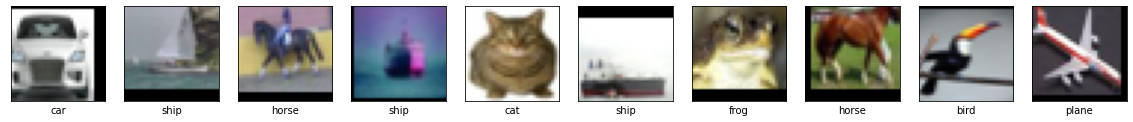

In [5]:
plt.figure(figsize=(20, 5))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(class_names[labels[i]])
  
    res = images[i].detach().clone()
    for i in range(3):
        res[i] = res[i] * STD[i] + MEAN[i]  
    
    npimg = res.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


define model

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.05),

            nn.Linear(4096, 512),
            nn.ReLU(),

            nn.Linear(512, 256),
            nn.ReLU(),

            nn.Dropout(p=0.05),

            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        return self.fc_layer(x)

model = CNN()
if CUDA:
    model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

fit

In [7]:
loss_list = []
accuracy_list = []

for epoch in range(EPOCHS):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        if CUDA:
            inputs, labels = inputs.cuda(), labels.cuda()
        
        optimizer.zero_grad()
        output = model(inputs)
        
        loss = criterion(output, labels)
        loss.backward()
        
        optimizer.step()

        running_loss += loss.item()
        if i % VERBOSE == VERBOSE - 1:
            print('epoch:', epoch + 1, 'batch:', i + 1, 'loss:', running_loss / VERBOSE)
            running_loss = 0.0 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch: 1 batch: 50 loss: 1.9680591464042663
epoch: 1 batch: 100 loss: 1.699585485458374
epoch: 1 batch: 150 loss: 1.5864415121078492
epoch: 1 batch: 200 loss: 1.4707134246826172
epoch: 1 batch: 250 loss: 1.444121253490448
epoch: 1 batch: 300 loss: 1.403059434890747
epoch: 1 batch: 350 loss: 1.3365304160118103
epoch: 2 batch: 50 loss: 1.2443159437179565
epoch: 2 batch: 100 loss: 1.2234453058242798
epoch: 2 batch: 150 loss: 1.1481268906593323
epoch: 2 batch: 200 loss: 1.1531856274604797
epoch: 2 batch: 250 loss: 1.0993015575408935
epoch: 2 batch: 300 loss: 1.0761600697040559
epoch: 2 batch: 350 loss: 1.0692563188076019


accuracy for each label

In [8]:
correct_pred = {cls: 0 for cls in class_names}
total_pred = {cls: 0 for cls in class_names}

for data in testloader:
    inputs, labels = data
    if CUDA:
        inputs = inputs.cuda()
        labels = labels.cuda()

    outputs = model(inputs)
    _, predictions = torch.max(outputs, 1)
    
    for label, prediction in zip(labels, predictions):
        if label == prediction:
            correct_pred[class_names[label]] += 1
        total_pred[class_names[label]] += 1

for cls in correct_pred:
    print('class:', cls, 'accuracy:', 100 * correct_pred[cls] / total_pred[cls])

class: plane accuracy: 74.2
class: car accuracy: 81.8
class: bird accuracy: 34.8
class: cat accuracy: 44.5
class: deer accuracy: 69.9
class: dog accuracy: 33.8
class: frog accuracy: 72.3
class: horse accuracy: 71.9
class: ship accuracy: 71.5
class: truck accuracy: 83.8
